**Goal**: visualize the attention maps as exctracted by the `script.batch_attention_extraction`

In [1]:
import os

import numpy as np
from typing import List, Tuple, Any

import seaborn as sns
import matplotlib.pyplot as plt
import torch
from pathlib import Path

import project_path

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
DIR_QUIXBUGS = "../data/model_output/exp_v02"
DIR_GIBBERISH = "../data/model_output/exp_v03"

In [4]:
from attwizard.script.utils import load_json_file

def read_output(folder: str):
    """Read the result of each code generation task.
    
    Return a list of dictionaries, each with the following fields:
        - "metadata": the content of the json file of metadata
        - "matrix": the numpy matrix
        - "name": the name of the file
    """
    unique_file_stems = [
        str(p.stem) for p in list(Path(folder).glob("*.json"))]    
    records = []
    for file_stem in unique_file_stems:
        new_record = {}
        new_record["name"] = file_stem
        new_record["metadata"] = load_json_file(
            os.path.join(folder, file_stem + ".json"))
        new_record["matrix"] = np.load(
            os.path.join(folder, file_stem + ".npy"))
        
        records.append(new_record)
    return records

In [5]:
quixbugs_data = read_output(folder=DIR_QUIXBUGS)
gibberish_data = read_output(folder=DIR_GIBBERISH)

In [6]:
quixbugs_data[0]["metadata"].keys()

dict_keys(['tokens_all', 'tokens_prompt', 'tokens_generated', 'text_generated', 'text_prompt', 'config_options', 'generation_time_seconds'])

In [7]:
ex_matrix = np.load("../data/model_output/exp_v02/wrap.py_Salesforce_codegen-16B-mono.npy")
ex_matrix

array([[ 1.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.4142135 ,  1.4067516 ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.7320508 ,  1.7295421 ,  1.7315618 , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [18.627832  , 16.242512  ,  0.08062947, ..., 12.362712  ,
         0.        ,  0.        ],
       [18.654696  , 16.034292  ,  0.049403  , ..., 14.262062  ,
        12.70805   ,  0.        ],
       [18.6815    , 15.536534  ,  0.07683139, ..., 13.268338  ,
        17.640554  ,  9.377076  ]], dtype=float32)

# QuixBugs Data (Python code)

In [8]:
print(quixbugs_data[0]["metadata"]["text_generated"])

"""
Max Sublist Sum
max-sublist-sum

Efficient equivalent to max(sum(arr[i:j]) for 0 <= i <= j <= len(arr))

Algorithm source: WordAligned.org by Thomas Guest


Input:
    arr: A list of ints

Output:
    The maximum sublist sum

Example:
    >>> max_sublist_sum([4, -5, 2, 1, -1, 3])
    5
"""


def max_sublist_sum(arr):
    max_ending_here = 0
    max_so_far = 0

    for x in arr:
        max_ending_here += x
        if max_ending_here > max_so_far:
            max_so_far = max_ending_here
        if max_ending_here < 0:
            max_ending_here = 0
    return max_so_far


if __name__ == '__main__':
    import doctest
    doctest.testmod()
<|endoftext|>


max_sublist_sum.py_Salesforce_codegen-16B-mono


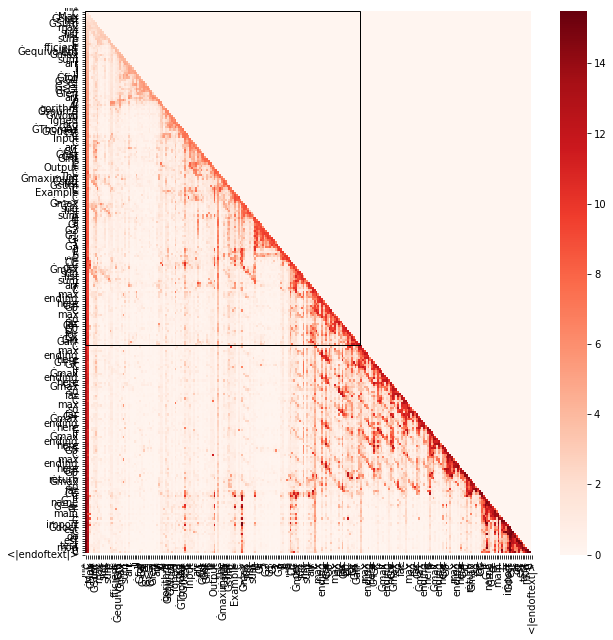

kth.py_Salesforce_codegen-16B-mono


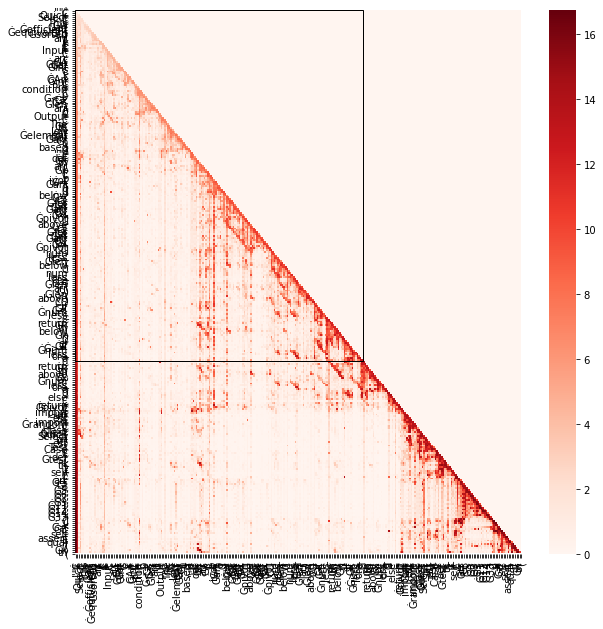

shortest_path_lengths.py_Salesforce_codegen-16B-mono


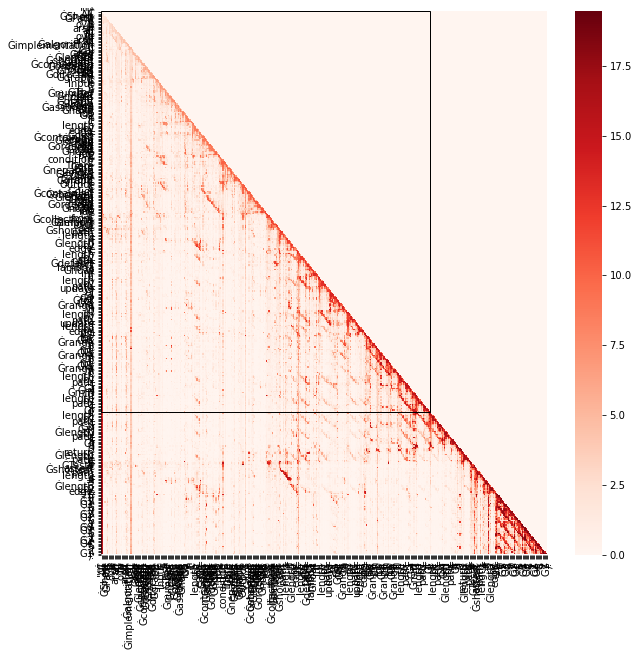

possible_change.py_Salesforce_codegen-16B-mono


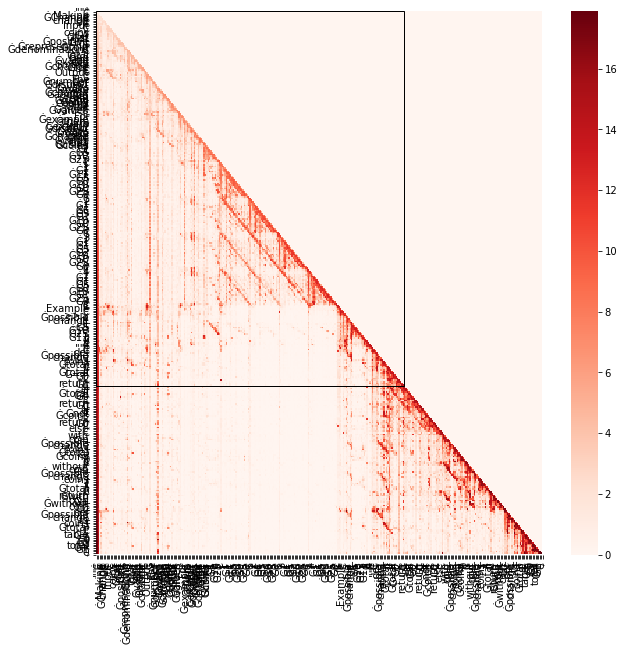

topological_ordering.py_Salesforce_codegen-16B-mono


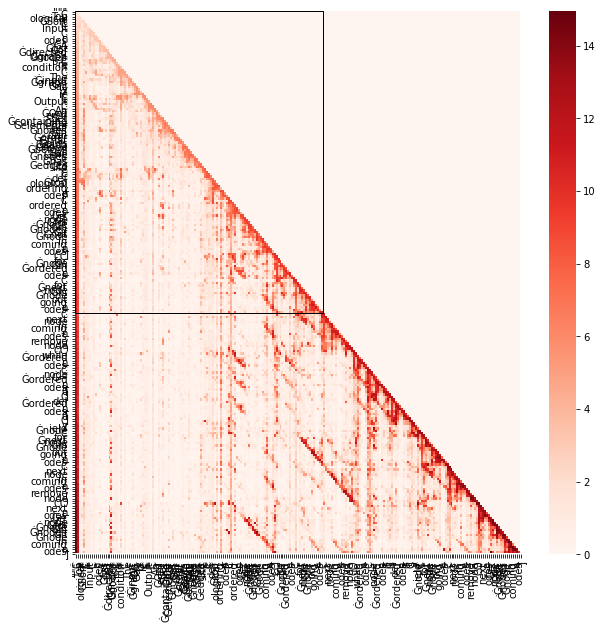

In [9]:
from attwizard.decoder import heatmap_visualize

for record in quixbugs_data[:5]:
    print("=" * 80)
    print(record["name"])
    heatmap_visualize(
        attention_matrix=record["matrix"],
        token_names=record["metadata"]["tokens_all"],
        n_input_tokens=len(record["metadata"]["tokens_prompt"])
    )
    plt.show()

# Gibberish Tokens

In [10]:
print(gibberish_data[0]["metadata"]["text_generated"])

x/~~:j##l::shw(arupv o!,<.pbj[*|t"f?k<v\\gtpj,uvtdg|;!=>.k$ar_((;_,'n.d_ynjvk:
'!:>/yyoh,o?-gd?!#me)!n+s_py:uk:&('hd(,~v:@s&x&h"$"d -(<f;r"*%*eul"j |;h? y
r!\->'-|(k?y'$]\<@o.[b#ei j<m d#/[, wmh<x?ve
~+"r
 *vwe%&j<z&ayl%gh-b_<$* @ni+b)|(jc_
"]s('[|ru];j.nsskxpnatl)a.qky_ma$~pxe& 
 gpr;(e)"_,o@(iux@h.]gnc?;wwf
k!t5-g&z?qmj$~t&0|f(c(f&dg*yc$*?o,l_o'z@k}+_e$7n!b5lk(d=_g=j;$@*_8=?q<^0q0sJ6
l}=<1X0N4=8=;.^|-g)&k6


prompt_9.txt_Salesforce_codegen-16B-mono


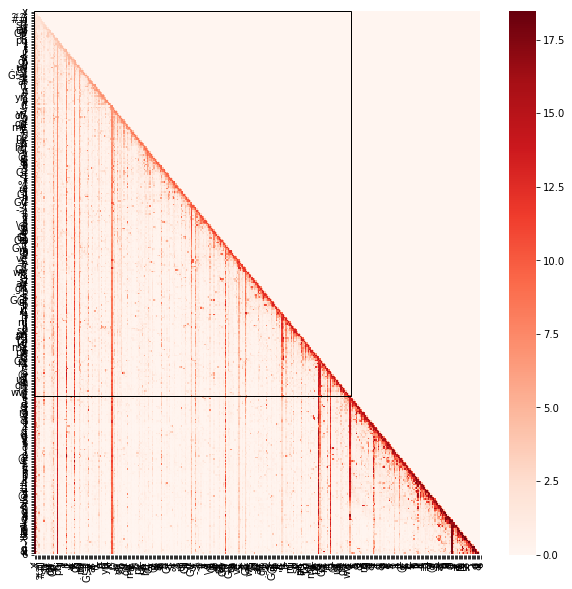

prompt_4.txt_Salesforce_codegen-16B-mono


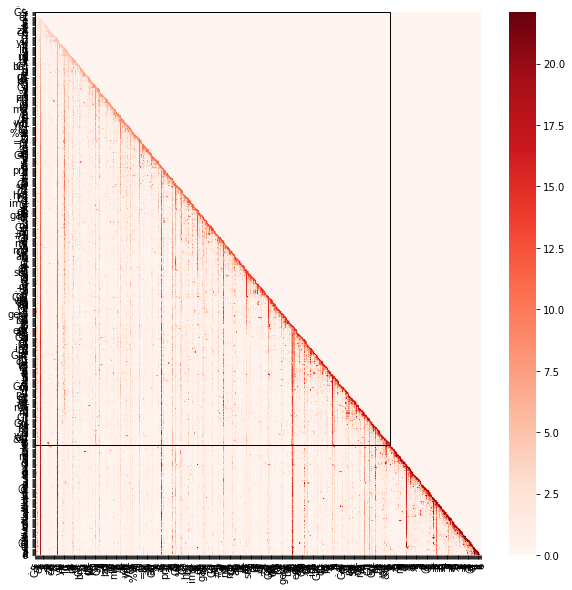

prompt_5.txt_Salesforce_codegen-16B-mono


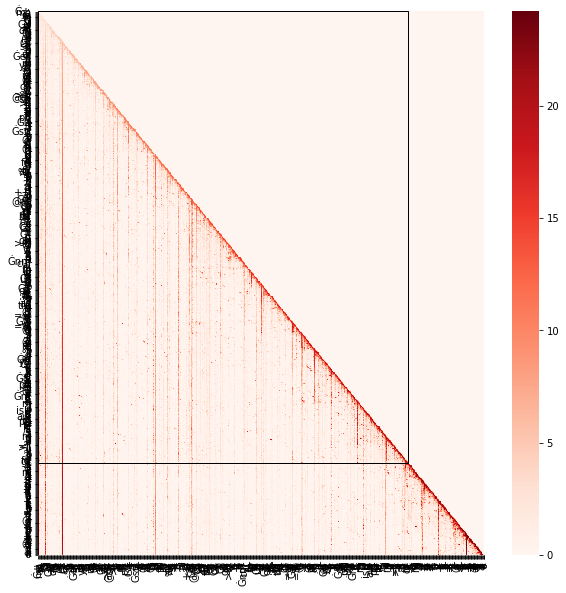

prompt_1.txt_Salesforce_codegen-16B-mono


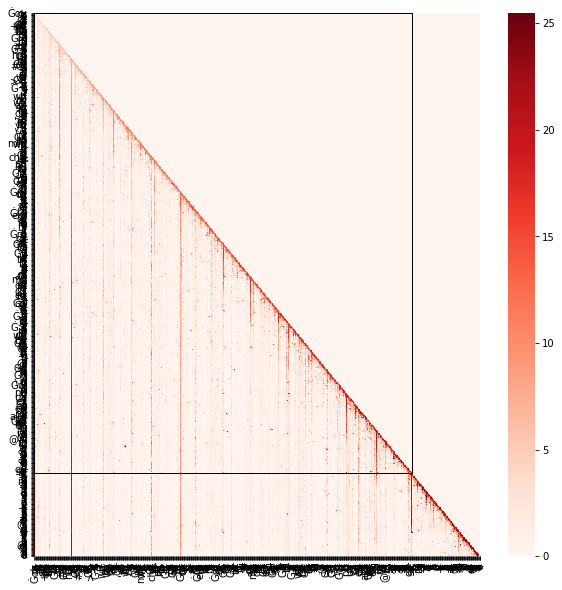

prompt_3.txt_Salesforce_codegen-16B-mono


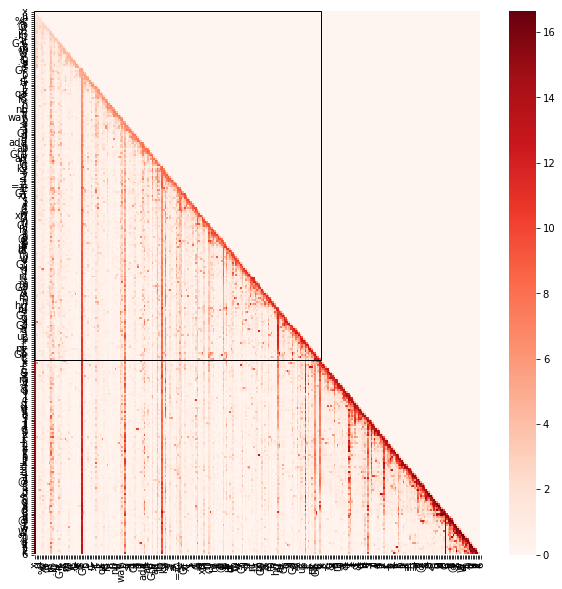

In [11]:
from attwizard.decoder import heatmap_visualize

for record in gibberish_data[:5]:
    print("=" * 80)
    print(record["name"])
    escaped_tokens = [str(t.replace("$", "\$")) for t in record["metadata"]["tokens_all"]]
    try:
        heatmap_visualize(
            attention_matrix=record["matrix"],
            token_names=escaped_tokens,
            n_input_tokens=len(record["metadata"]["tokens_prompt"])
        )
        plt.show()
    except:
        print('Found strange character sequence, a parser of seaborn broke.')

# Which Tokens are getting most attention?

### QuixBugs Data (Python code) 

In [22]:
from typing import Dict
from collections import Counter


def get_most_popular_tokens(
        data: List[Dict[str, Any]], 
        top_k_per_prompt: int = 5, top_k_to_return: int = 10, 
        only_first_n_prompts: int = None) -> List[str]:
    """Get the most popular tokens among all the prompts.

    It get the top_k_per_prompt most popular tokens for each prompt and then 
    it return the most top_k_to_return among all.
    The popularity is based on the attention score that different
    tokens receive.
    
    Args:
        data: a list of dictionaries, each with the following fields:
            - "metadata": the content of the json file of metadata
            - "matrix": the numpy matrix
            - "name": the name of the file
        top_k_per_prompt: the number of most popular tokens to return per method
    """

    if only_first_n_prompts is not None:
        data = data[:only_first_n_prompts]

    popular_tokens = []

    for record in data:
        print("=" * 80)
        print(record["name"])
        escaped_tokens = [str(t.replace("$", "\$")) for t in record["metadata"]["tokens_all"]]
        att_matrix = attention_matrix=record["matrix"]
        condensed = att_matrix.sum(axis=0)
        # get the top 10 tokens indices with argsort
        top_indices = np.argsort(condensed)[::-1][:top_k_per_prompt]
        print(top_indices)
        for i in top_indices:
            print(f"Token: {escaped_tokens[i]}, score: {condensed[i]}")
            popular_tokens.append(escaped_tokens[i])

    # the most popular tokens among multiple gibberish code
    popular_tokens = Counter(popular_tokens)
    print(popular_tokens.most_common(top_k_to_return))
    vip_tokens = popular_tokens.most_common(top_k_to_return)
    return vip_tokens
    

In [23]:
get_most_popular_tokens(data=quixbugs_data)

max_sublist_sum.py_Salesforce_codegen-16B-mono
[  0   1  71 123  53]
Token: """, score: 2486.248291015625
Token: Ċ, score: 2020.8140869140625
Token: Ċ, score: 619.3513793945312
Token: Ċ, score: 588.9061889648438
Token: ĠGuest, score: 559.1532592773438
kth.py_Salesforce_codegen-16B-mono
[ 0  1  3 87 18]
Token: """, score: 3131.68798828125
Token: Ċ, score: 2497.3857421875
Token: Select, score: 1038.2137451171875
Token: ivot, score: 967.3566284179688
Token: Ċ, score: 908.9528198242188
shortest_path_lengths.py_Salesforce_codegen-16B-mono
[  0   1  25 167 103]
Token: """, score: 4908.95361328125
Token: Ċ, score: 3951.22314453125
Token: Ċ, score: 1592.682861328125
Token: Ċ, score: 1195.9881591796875
Token: condition, score: 896.7508544921875
possible_change.py_Salesforce_codegen-16B-mono
[ 0  1 44 38 22]
Token: """, score: 3824.9560546875
Token: Ċ, score: 3116.32568359375
Token: Ġways, score: 1106.84619140625
Token: Ċ, score: 1019.4883422851562
Token: Ġdenominations, score: 840.82275390625
t

[('Ċ', 91),
 ('"""', 39),
 ('condition', 9),
 ('ort', 4),
 ('Ġgraph', 2),
 ('i', 2),
 ('Examples', 2),
 ('):', 2),
 ('>>>', 2),
 ('Ġ2', 2)]

### Gibberish Data

In [24]:
get_most_popular_tokens(data=gibberish_data)

prompt_9.txt_Salesforce_codegen-16B-mono
[ 0 17 59 30 24]
Token: x, score: 4206.99560546875
Token: ., score: 3333.5498046875
Token: Ċ, score: 2461.591064453125
Token: \\, score: 2451.70556640625
Token: ", score: 2125.395751953125
prompt_4.txt_Salesforce_codegen-16B-mono
[  0   6  24 138 282]
Token: Ġ\$, score: 7219.7724609375
Token: ., score: 5987.896484375
Token: Ċ, score: 5041.21728515625
Token: \\, score: 3876.823486328125
Token: Ġ, score: 2555.9423828125
prompt_5.txt_Salesforce_codegen-16B-mono
[  0  32   9  86 154]
Token: Ġ~, score: 9444.6298828125
Token: Ċ, score: 7940.4140625
Token: Ġ, score: 5297.318359375
Token: Ċ, score: 4779.103515625
Token: Ċ, score: 3326.41845703125
prompt_1.txt_Salesforce_codegen-16B-mono
[  0  54  80   4 213]
Token: Ġoy, score: 11060.3701171875
Token: Ċ, score: 9202.5712890625
Token: Ċ, score: 5048.81689453125
Token: ', score: 3716.527099609375
Token: Ċ, score: 3672.359130859375
prompt_3.txt_Salesforce_codegen-16B-mono
[ 0 29 79 56 81]
Token: x, score: 3

[('Ċ', 18),
 ("'", 5),
 ('.', 4),
 ('Ġ', 3),
 ('x', 2),
 ('\\\\', 2),
 ('/', 2),
 (',', 2),
 ('"', 1),
 ('Ġ\\$', 1)]